In [13]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
COLORS = [(22/255, 105/255, 122/255), (72/255, 159/255, 181/255), (130/255, 192/255, 204/255), 
          (237/255, 231/255, 227/255), (255/255, 166/255, 43/255)]

## Correlación: fluorescencia - motilidad

encodes (1658, 20)
tracks (162119, 5)
ids 1658
frames 119


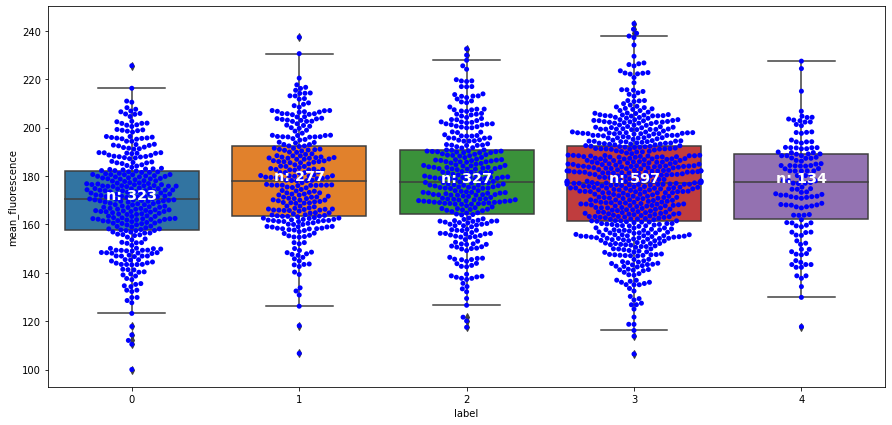

In [7]:
encodes = np.load('data/simulation_30hz/encodes.npy')
tracks = np.genfromtxt('data/simulation_30hz/trajectories.csv', delimiter=',', skip_header=True)
ids = np.unique(tracks[:, 0])
frames = np.unique(tracks[:, 4])
# id,x,y,fluorescence,frame
print('encodes', encodes.shape)
print('tracks', tracks.shape)
print('ids', len(ids))
print('frames', len(frames))

scaler = StandardScaler()
encodes_scaled = scaler.fit_transform(encodes)

km = KMeans(n_clusters=5)
# km.fit(encodes)
km.fit(encodes_scaled)

tracks_info = pd.DataFrame(columns=['id', 'label', 'mean_fluorescence'])
tracks_info['id'] = ids
tracks_info['label'] = km.labels_
# print(tracks_info)
mean_fluorescence = []
for k, track_id in enumerate(ids):
    track = tracks[tracks[:, 0] == track_id]
    mean_fluorescence.append(np.nanmean(track[track[:, 3] != 0][:, 3]))
tracks_info['mean_fluorescence'] = mean_fluorescence

fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="label", y="mean_fluorescence", data=tracks_info)
medians = tracks_info.groupby(['label'])['mean_fluorescence'].median().values
nobs = ["n: " + str(tracks_info['label'].value_counts()[i]) for i in sorted(tracks_info['label'].value_counts().index)]

# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-large', color='w', weight='semibold')

ax = sns.swarmplot(x='label', y='mean_fluorescence', data=tracks_info, color="blue")
plt.show()

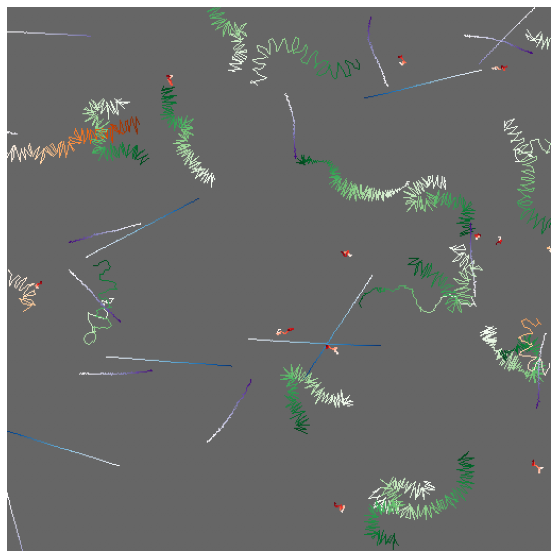

In [8]:
plt.figure(figsize=(10,10))
# colors = ['r', 'c', 'g', 'y']
color_maps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']
random_ids = np.random.choice(ids, size=50, replace=False)
img = np.ones((512,512,3))*0.4
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    cmap = plt.get_cmap(color_maps[label])
    for i, frame in enumerate(track[:, 4][:-1]):
        coords = track[track[:, 4] == frame][0][1:3]
        next_coords = track[track[:, 4] == frame+1][0][1:3]
        color = cmap(i/len(frames))
        color = colors.to_rgb(color)
        cv2.line(img, tuple(coords.astype(int)), tuple(next_coords.astype(int)), color=color)
#     plt.plot(track[:, 1], track[:, 2], c=colors[label], alpha=0.7)
plt.imshow(img)
plt.axis('off')
plt.show()


## Casificación en función de la motilidad

In [9]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

encodes shape: (1658, 20)


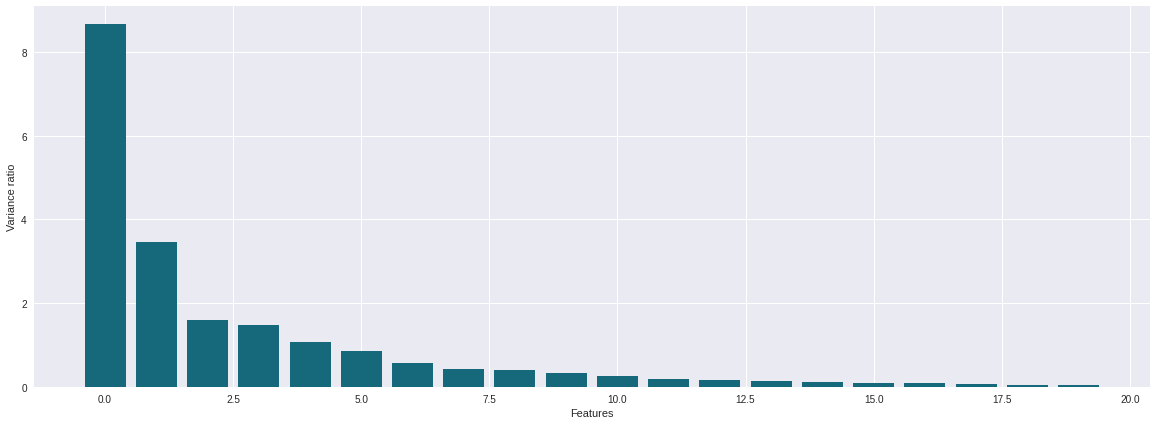

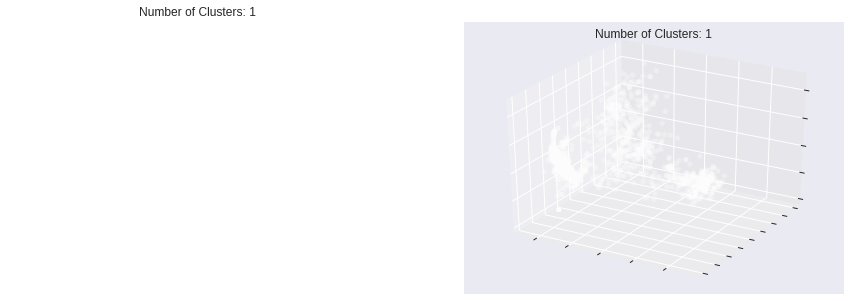

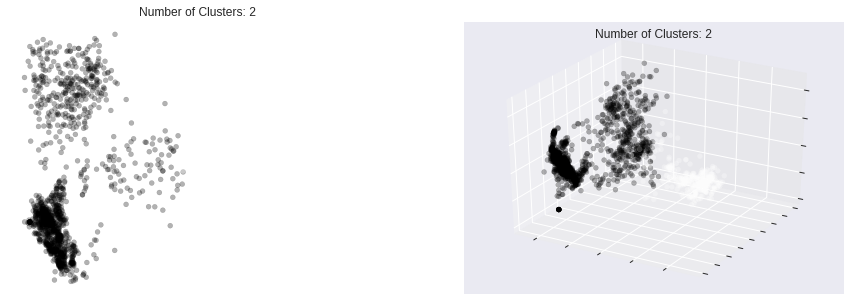

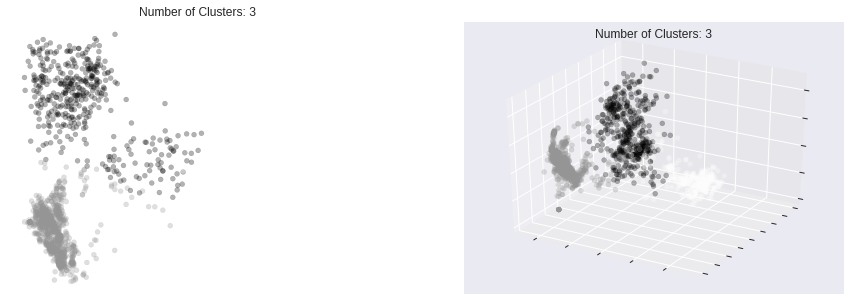

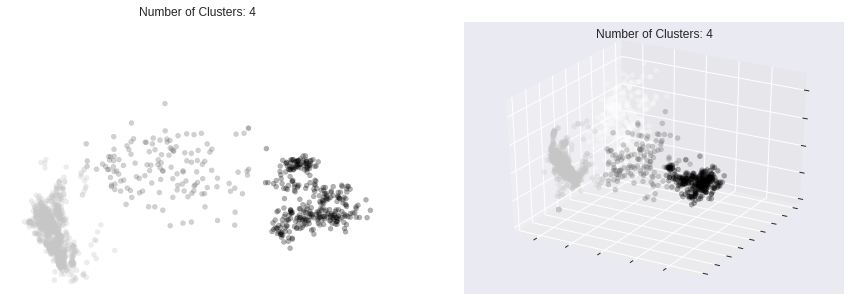

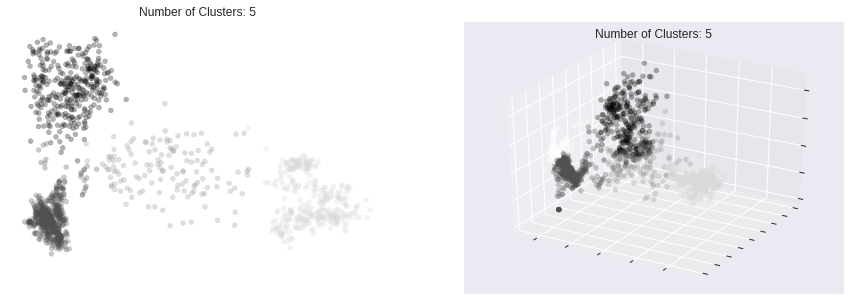

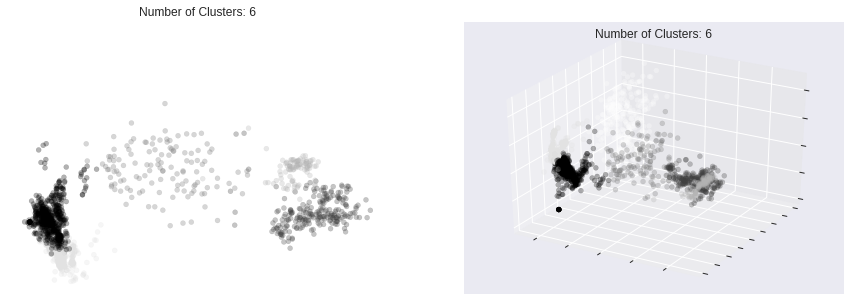

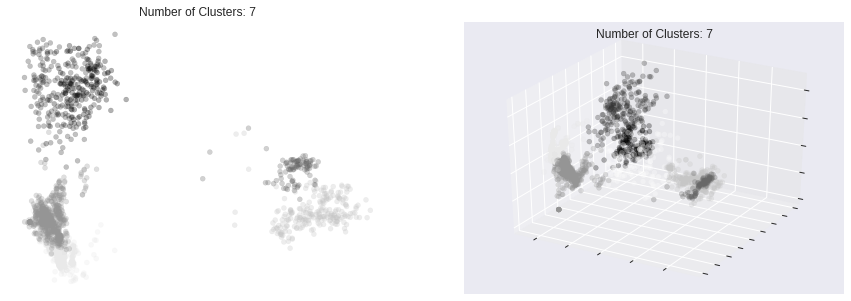

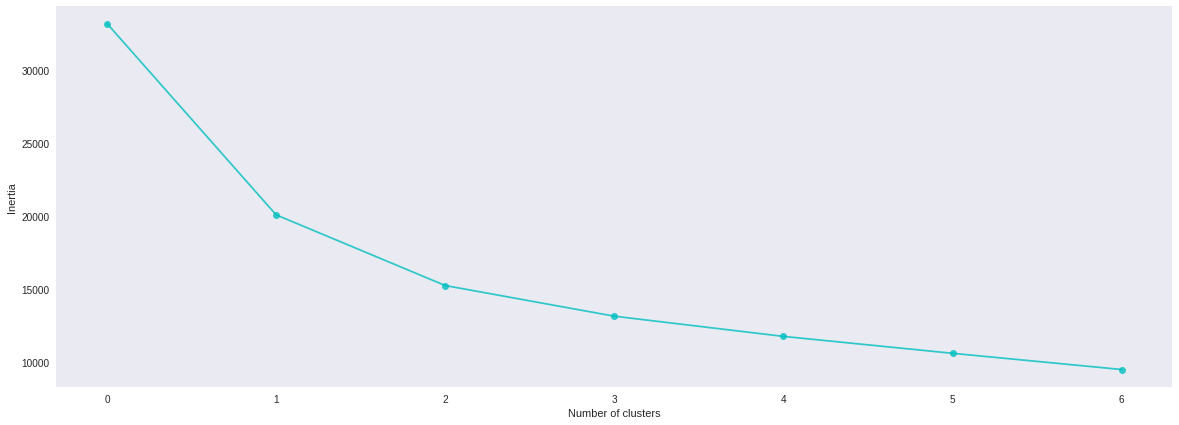

In [24]:

print('encodes shape:', encodes.shape)
# normalize
scaler = StandardScaler()
encodes_scaled = scaler.fit_transform(encodes)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(encodes_scaled)
pca_variance = pca.explained_variance_

# plt.style.use('seaborn')
plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, color=COLORS[0])
plt.ylabel('Variance ratio')
plt.xlabel('Features')
# plt.savefig('clustering_sim_var.png', bbox_inches='tight')
plt.show()

# plt.style.use('_classic_test_patch')
inertias = []
for i in range(1, 8):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    kmeans = KMeans(n_clusters=i)
    y_pred = kmeans.fit_predict(encodes_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.3)
    plt.title(f"Number of Clusters: {i}")
    plt.axis('off')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.3)
    plt.title(f"Number of Clusters: {i}")
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_zticklabels(), visible=False)
    inertias.append(kmeans.inertia_)
    if i in (3, 4, 5):
        plt.savefig('clustering_sim_pca_k' + str(i) + '.png', bbox_inches='tight', dpi=200)
    plt.show()

plt.figure(figsize=(20,7))
plt.plot(inertias, '-o', alpha=0.8, c='c')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.grid()
plt.show()

## Populations

In [6]:
gt_tracks = pd.read_csv('data/simulation_30hz/clustering_dataset(30Hz)_data.csv')
gt_tracks.head()

,id_particle,x,y,fluorescence,frame,type,id
0,NaN,385.814134,49.772342,153.368660,0.0,a,1.0
1,NaN,460.359668,284.220887,179.996788,0.0,a,20.0
2,NaN,5.708772,120.126388,222.440429,0.0,a,21.0
3,NaN,53.403237,161.207419,173.080079,0.0,a,44.0
4,NaN,160.804209,458.370720,169.447703,0.0,a,57.0


In [ ]:
gt_types = pd.DataFrame()
track_ids = sorted(gt_tracks['id'].unique())
track_types = [gt_tracks[gt_tracks['id']==track_id]['type'].unique()[0] for _, track_id in enumerate(track_ids)]
track_fluo = [gt_tracks[gt_tracks['id']==track_id]['fluorescence'].unique()[0] for _, track_id in enumerate(track_ids)]
gt_types['id'] = track_ids
gt_types['type'] = track_types
gt_types['fluorescence'] = track_fluo
sim_types = gt_tracks['type'].unique()

fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="type", y="fluorescence", data=gt_types)
medians = gt_types.groupby(['type'])['fluorescence'].median()
counts = gt_types['type'].value_counts()
# Add it to the plot
pos = range(len(nobs))
for i, sim_type in enumerate(sim_types):
    median = medians[sim_type]
    num = counts[sim_type]
    print(num, median)
    ax.text(i, median, num, horizontalalignment='center', size='x-large', color='w', weight='semibold')

# ax = sns.swarmplot(x='motility_type', y='fluo', data=who_classification, color="blue")
plt.show()

IndexError: list index out of range

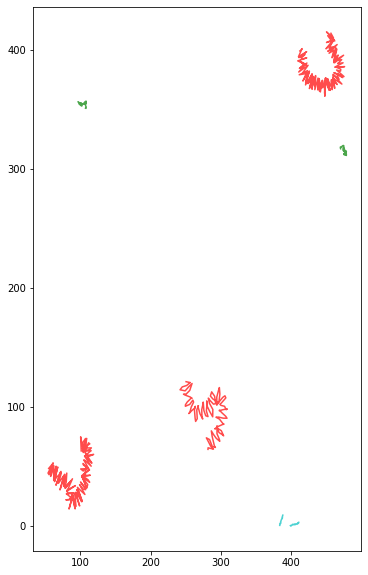

In [46]:
plt.figure(figsize=(20,10))
plt.subplot(131)
colors = ['r', 'c', 'g', 'y']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
random_ids = np.random.choice(ids, size=50, replace=False)
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[label], alpha=0.7)
plt.legend(lines, tracks_info['label'].unique(), loc='upper right')
plt.title('Clasificación automática')
plt.axis('off')

plt.subplot(132)
for random_id in random_ids:
    label = who_classification[who_classification['track_id'] == random_id]['motility_type'].values
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(motility_types == label)[0][0]], alpha=0.7)
    
plt.title('Clasificación OMS')
plt.legend(lines, who_classification['motility_type'].unique(), loc='upper right')
plt.axis('off')
    
plt.subplot(133)
for random_id in random_ids:
    label = gt_types[gt_types['id'] == random_id]['type'].values
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(sim_types == label)[0][0]], alpha=0.7)
    
plt.title('Simulation type')
plt.legend(lines, sim_types, loc='upper right')
plt.axis('off')
plt.savefig('cluster_sim_tracks.png', bbox_inches='tight')
plt.show()


## Who classification

437 179.5162179393534
400 175.496699607133
399 175.9803694634785
422 172.12241125425743


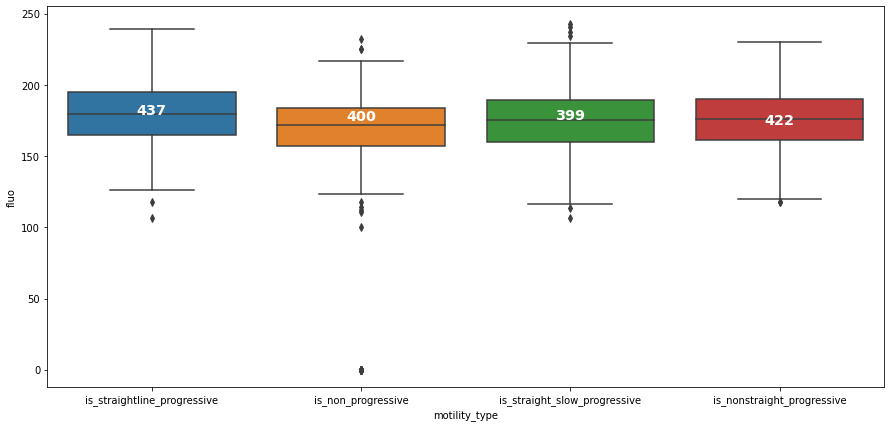

In [47]:
who_classification = pd.read_csv('data/simulation_30hz/who_classification.csv', index_col=False)
motility_types = ['is_straightline_progressive', 'is_straight_slow_progressive', 'is_nonstraight_progressive', 'is_non_progressive']

fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="motility_type", y="fluo", data=who_classification)
medians = who_classification.groupby(['motility_type'])['fluo'].median()
counts = who_classification['motility_type'].value_counts()
# Add it to the plot
pos = range(len(nobs))
for i, motility_type in enumerate(motility_types):
    median = medians[motility_type]
    num = counts[motility_type]
    print(num, median)
    ax.text(i, median, num, horizontalalignment='center', size='x-large', color='w', weight='semibold')

# ax = sns.swarmplot(x='motility_type', y='fluo', data=who_classification, color="blue")
plt.show()



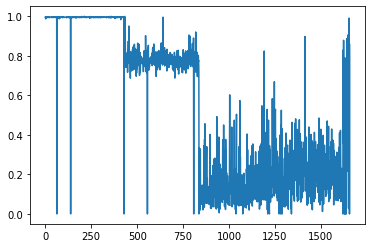

In [48]:
# print(who_classification['lin'])
plt.plot(who_classification['lin'])

In [49]:
encodes = np.load('data/simulation_30hz/encodes.npy')

who_labels_legend = ['straight-line progressive',  'straight-slow progressive', 'non-straight progressive', 'non progressive']
print(motility_types)
print(who_labels_legend)

who_labels_int = [motility_types.index(label) for label in who_classification['motility_type']]


['is_straightline_progressive', 'is_straight_slow_progressive', 'is_nonstraight_progressive', 'is_non_progressive']
['straight-line progressive', 'straight-slow progressive', 'non-straight progressive', 'non progressive']


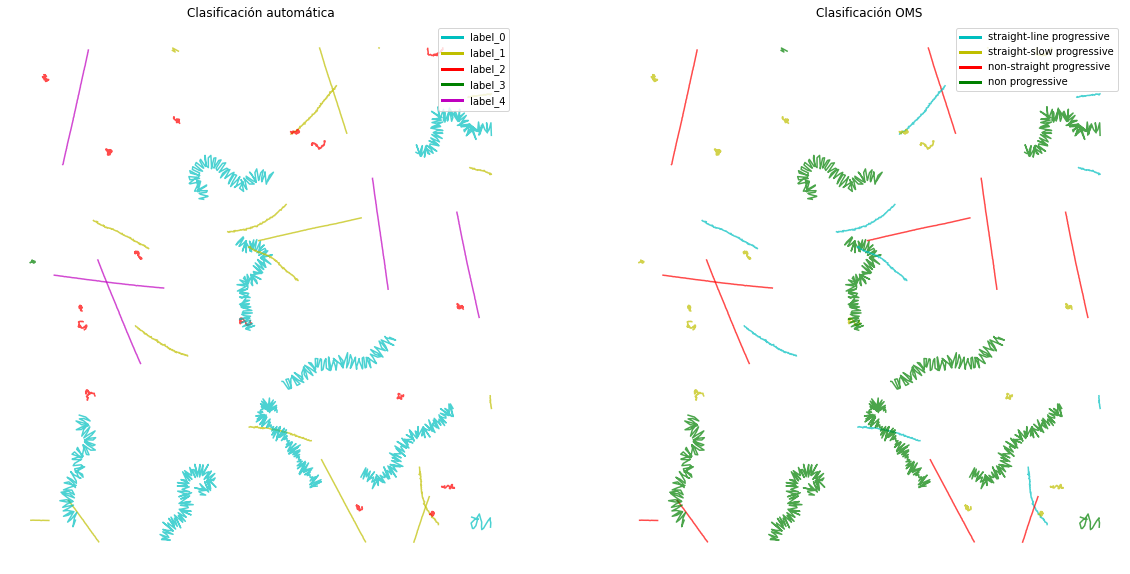

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(121)
colors = ['r', 'c', 'g', 'y']
colors_kmeans = ['c', 'y', 'r', 'g', 'm']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors_kmeans]
random_ids = np.random.choice(ids, size=50, replace=False)
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors_kmeans[label], alpha=0.7)
plt.legend(lines, ['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], loc='upper right')
plt.title('Clasificación automática')
plt.axis('off')

plt.subplot(122)
for random_id in random_ids:
    label = who_classification[who_classification['track_id'] == random_id]['motility_type'].values
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(motility_types == label)[0][0]], alpha=0.7)
    
plt.title('Clasificación OMS')
plt.legend(lines, who_labels_legend, loc='upper right')
plt.axis('off')
plt.savefig('cluster_sim_tracks.png', bbox_inches='tight')
plt.show()


## Who classification and trajectory encoding

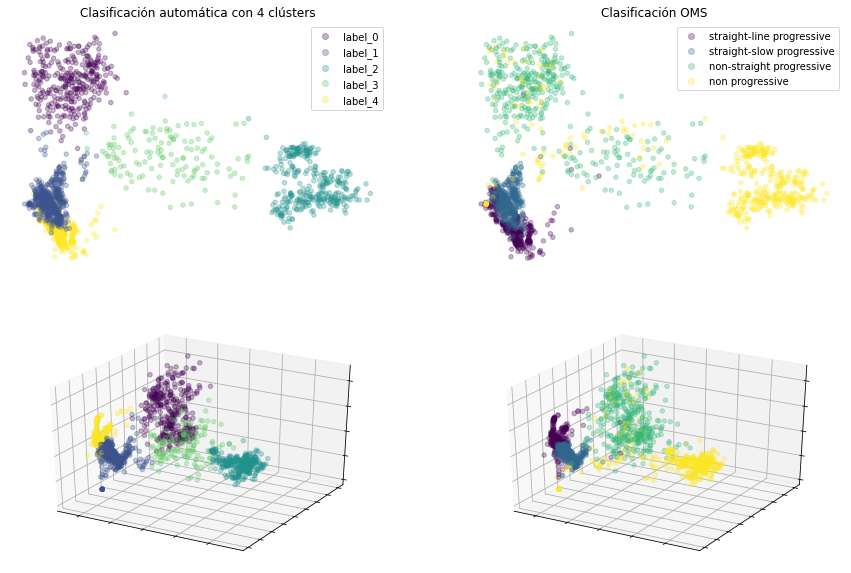

In [51]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=tracks_info['label'], s=20, alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], loc='upper right')
plt.title("Clasificación automática con 4 clústers")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=who_labels_int, s=20, alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación OMS")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=tracks_info['label'], s=20, alpha=0.3)
# plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=who_labels_int, s=20, alpha=0.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

# plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend)
plt.savefig('clusters_sim_oms.png', dpi=200, bbox_inches='tight')
plt.show()

## Urbano

Text(0.5, 0, 'ALH')

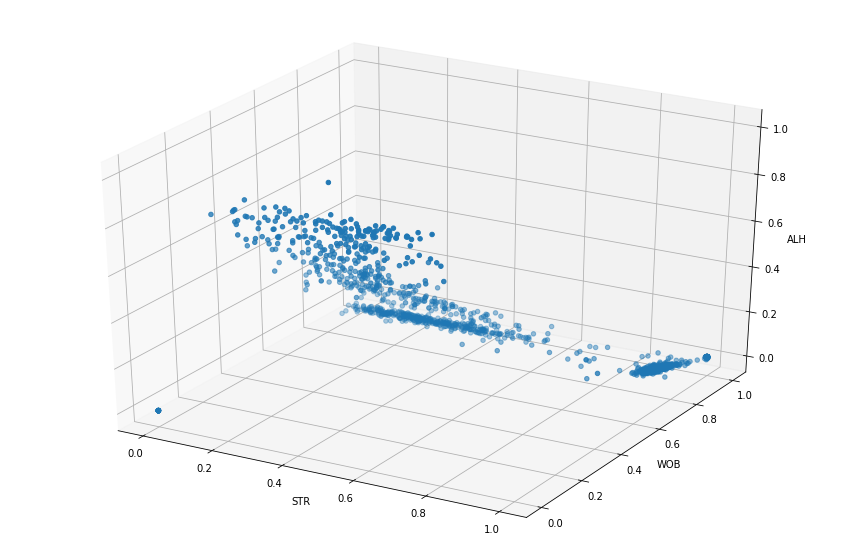

In [32]:
who_features = who_classification[['alh_mean', 'wob', 'str']]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(who_features['str']/who_features['str'].max(), who_features['wob']/who_features['wob'].max()
           , who_features['alh_mean']/who_features['alh_mean'].max())
ax.set_xlabel('STR')
ax.set_ylabel('WOB')
ax.set_zlabel('ALH')
# plt.show()

Text(0, 0.5, 'fluo')

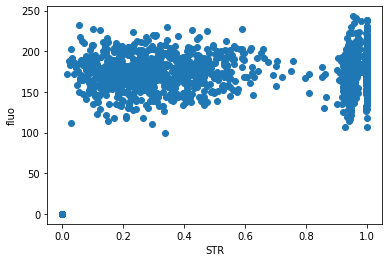

In [33]:
# print(who_classification)
plt.scatter(who_classification['str'], who_classification['fluo'])
plt.xlabel('STR')
plt.ylabel('fluo')
# plt.show()


## SVM - WHO

In [54]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [55]:
encodes = np.load('data/simulation_30hz/encodes.npy')

In [56]:
X = encodes
y = who_classification['motility_type']
N = encodes.shape[0]
labels = who_classification['motility_type'].unique()
print('labels:\n', labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

train_indices = np.random.choice(range(N), size=8*N//10, replace=False)
val_indices = [i for i in range(N) if i not in train_indices]
X_train = X[train_indices, :]
y_train = y[train_indices]

X_val = X[val_indices, :]
y_val = y[val_indices]
print('Num train {}'.format(len(train_indices)))
print('Num val {}'.format(len(val_indices)))

labels:
 ['is_straightline_progressive' 'is_non_progressive'
 'is_straight_slow_progressive' 'is_nonstraight_progressive']
Num train 1326
Num val 332


In [57]:
for label in labels:
    print('label {} in train: {:.2f}%'.format(label, 100*np.sum(y_train==label)/len(y_train)))

label is_straightline_progressive in train: 27.00%
label is_non_progressive in train: 25.41%
label is_straight_slow_progressive in train: 23.98%
label is_nonstraight_progressive in train: 23.60%


Train accuracy 0.96


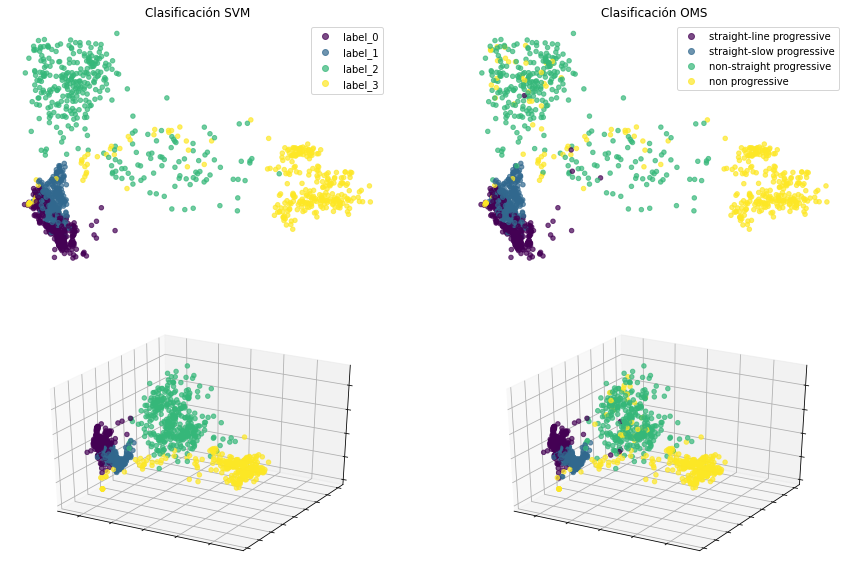

In [63]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print('Train accuracy {:.2f}'.format(np.sum(y_pred==y_train)/len(y_train)))

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pca.fit_transform(X_train_scaled)

pred_labels = [np.argwhere(np.array(motility_types) == label)[0][0] for _, label in enumerate(y_pred)]
train_labels = [np.argwhere(np.array(motility_types) == label)[0][0] for _, label in enumerate(y_train)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=pred_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2', 'label_3'], loc='upper right')
plt.title("Clasificación SVM")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación OMS")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], c=pred_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], c=train_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

plt.savefig('svm_sim_oms_train.png', dpi=200, bbox_inches='tight')
plt.show()

Accuracy 0.96


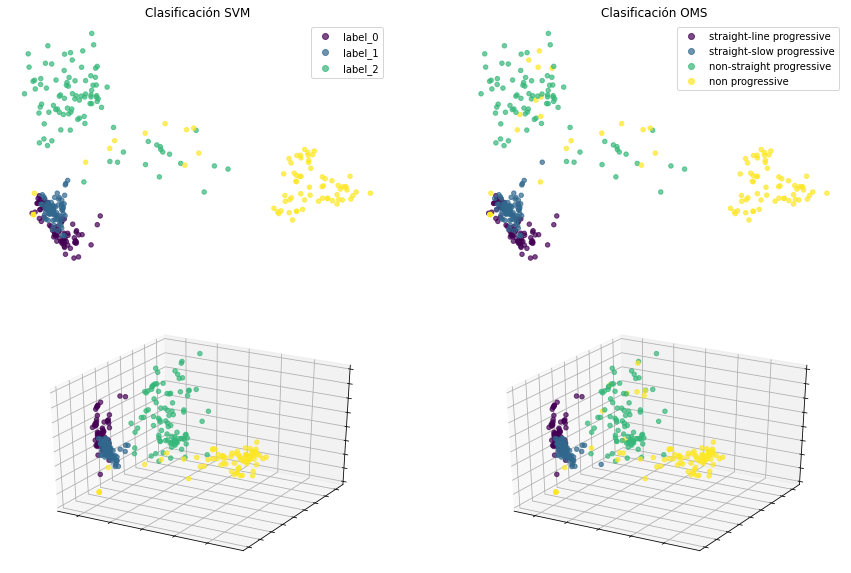

In [65]:
y_pred = clf.predict(X_val)
print('Accuracy {:.2f}'.format(np.sum(y_pred==y_val)/len(y_val)))

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pca.fit_transform(X_val_scaled)
pred_labels = [np.argwhere(np.array(motility_types) == label)[0][0] for _, label in enumerate(y_pred)]
val_labels = [np.argwhere(np.array(motility_types) == label)[0][0] for _, label in enumerate(y_val)]


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=pred_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2'], loc='upper right')
plt.title("Clasificación SVM")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=val_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación OMS")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], X_val_scaled[:, 2], c=pred_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], X_val_scaled[:, 2], c=val_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

plt.savefig('svm_sim_oms_val.png', dpi=200, bbox_inches='tight')
plt.show()

In [40]:
video = '1_026'
encodes = np.load('data/individual/' + video + '/encodes.npy')
tracks = np.genfromtxt('data/individual/' + video + '/trajectories.csv', delimiter=',', skip_header=True)
ids = np.unique(tracks[:, 0])

labels = clf.predict(encodes)

plt.figure(figsize=(15,10))
colors = ['r', 'c', 'g', 'y']
for i, track_id in enumerate(ids):
    label = labels[i]
#     print(i, track_id, label)
    track = tracks[tracks[:, 0] == track_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(motility_types == label)[0][0]], alpha=0.7)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1080x720 with 0 Axes>